In [1]:
from classification_probes import ActivationDataset, ProbeTrainer, TextClassificationDataset, HookManager, ClassificationProbe
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM
from collections import defaultdict
from typing import Dict, List, Tuple, Any
from tqdm import tqdm
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from copy import deepcopy
import random
from scipy.stats import sem, t

from matplotlib.ticker import PercentFormatter
import seaborn as sns
#import seaborn as sns

In [2]:
# Initialize Variables
model_name = "AI-Sweden-Models/gpt-sw3-356m"
device = "cuda:0" if torch.cuda.is_available() else "cpu"
# Initialize Tokenizer & Model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)
model.eval()
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(64000, 1024)
    (wpe): Embedding(2048, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): GELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=64000, bias=False)
)

In [3]:
lab_map = {
    'nb': 0,
    'en': 1,
    'is': 2,
    'sv': 3,
    'da': 4
}

map_lab = {value: key for key, value in lab_map.items()}

data_loc = 'data/antibiotic/'
ds = TextClassificationDataset.from_txt(data_loc + 'nb.txt', lab_map['nb'])
ds.add_from_txt(data_loc + 'en.txt', lab_map['en'])
ds.add_from_txt(data_loc + 'is.txt', lab_map['is'])
#ds.add_from_txt(data_loc + 'nb.txt', lab_map['nb'])
ds.add_from_txt(data_loc + 'sv.txt', lab_map['sv'])

meta_data = {}

loader = DataLoader(ds, batch_size=32, shuffle=True)
try:
    meta_data["hidden_size"] = model.config.n_embd
except AttributeError:
    meta_data["hidden_size"] = model.config.hidden_size


meta_data["hidden_layers"] = model.config.num_hidden_layers
meta_data["model_name"] = model_name.split("/")[0]

In [4]:
def get_activations():

    res_stream_act_by_layer = dict()
    activation_ds_by_layer = {
        layer: ActivationDataset()
        for layer in range(meta_data["hidden_layers"])
    }

    for ind, (text, label) in enumerate(tqdm(loader)):

        if ind > 5:
            break

        tokenized = tokenizer(
            text,
            padding=True,
            truncation=True,
            return_tensors='pt'
        ).to(device)

        with HookManager(model) as hook_manager:
            for layer in range(meta_data["hidden_layers"]):
                res_stream_act_by_layer[layer] = hook_manager.attach_residstream_hook(
                    layer=layer,
                    pre_mlp=False,
                    pythia=False
                )

            model(**tokenized)

        # flattening [batch, pad_size, ...] to [tokens, ...]
        attn_mask = tokenized.attention_mask.flatten() # [tokens]
        label = label.unsqueeze(-1).expand(-1, tokenized.attention_mask.shape[1]).flatten() # [tokens]

        for layer in range(meta_data["hidden_layers"]):
            res_stream_act_by_layer[layer] = res_stream_act_by_layer[layer][0].view(-1, meta_data["hidden_size"]) # [tokens, hidden_size]
            activation_ds_by_layer[layer].add_with_mask(res_stream_act_by_layer[layer], label, attn_mask)



  6%|▌         | 6/105 [00:40<11:01,  6.68s/it]


In [5]:



s = set()
for i in range(meta_data["hidden_layers"]):
    unique_labels = set(np.array(activation_ds_by_layer[i].labels))
    [s.add(x) for x in unique_labels]

In [9]:
meta_data["learning_rate"] = 0.001
meta_data["reg_lambda"] = 10
meta_data["number_labels"] = len(s)
meta_data["amount_epochs"] = 1

boot = bootstrap(10, meta_data, activation_ds_by_layer)
d = defaultdict(list)
for run in boot:
    for layer in run.keys():
        class_accuracies = run[layer].class_accuracies
        d[layer].append(class_accuracies)

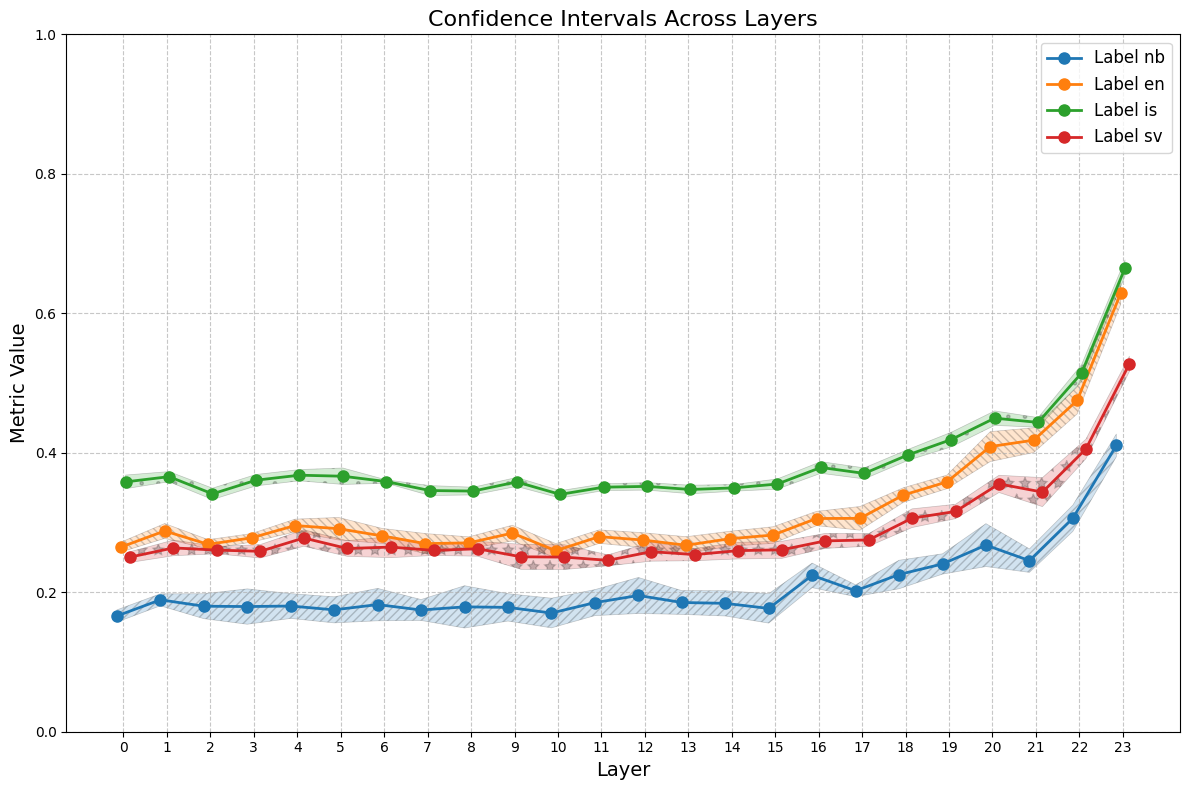

In [10]:
plot_confidence_intervals(d,meta_data)